In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
drive.mount('/content/drive')

npz_path = "/content/drive/MyDrive/SHIP32/ships_competition.npz"
zip_path = "/content/drive/MyDrive/SHIP32/ships.zip"
extract_path = "/content/ships_split"


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("TensorFlow version :", tf.__version__)


Mounted at /content/drive
TensorFlow version : 2.18.0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 32, 32
batch_size = 32

train_dir = f"{extract_path}/ships_split/train"
val_dir = f"{extract_path}/ships_split/val"

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    shear_range=0.15,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)


val_gen = ImageDataGenerator(rescale=1./255)

train_loader = train_gen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

val_loader = val_gen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

print("Classes :", train_loader.class_indices)


Found 38671 images belonging to 13 classes.
Found 9659 images belonging to 13 classes.
Classes : {'coastguard': 0, 'containership': 1, 'corvette': 2, 'cruiser': 3, 'cv': 4, 'destroyer': 5, 'ferry': 6, 'methanier': 7, 'sailing': 8, 'smallfish': 9, 'submarine': 10, 'tug': 11, 'vsmallfish': 12}


In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Bloc 1
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Bloc 2
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    # Bloc 3
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_loader.class_indices), activation='softmax')
])

print("Nombre de couches :", len(model.layers))
model.summary()


Nombre de couches : 25


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             

 Total params: 816,685 (3.12 MB)

 Trainable params: 815,789 (3.11 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
)

model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)
]

history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.7316 - loss: 0.7811 - val_accuracy: 0.6889 - val_loss: 0.9410 - learning_rate: 0.0010
Epoch 2/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7329 - loss: 0.7729 - val_accuracy: 0.7121 - val_loss: 0.8778 - learning_rate: 0.0010
Epoch 3/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7349 - loss: 0.7644 - val_accuracy: 0.7049 - val_loss: 0.8889 - learning_rate: 0.0010
Epoch 4/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.7401 - loss: 0.7503 - val_accuracy: 0.6956 - val_loss: 0.9034 - learning_rate: 0.0010
Epoch 5/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.7449 - loss: 0.7405 - val_accuracy: 0.7026 - val_loss: 0.8966 - learning_rate: 0.0010
Epoch 6/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7529 - loss: 0.7190 - val_accuracy: 0.7024 - val_loss: 0.9229 - learning_rate: 0.0010
Epoch 7/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step -

KeyboardInterrupt: 

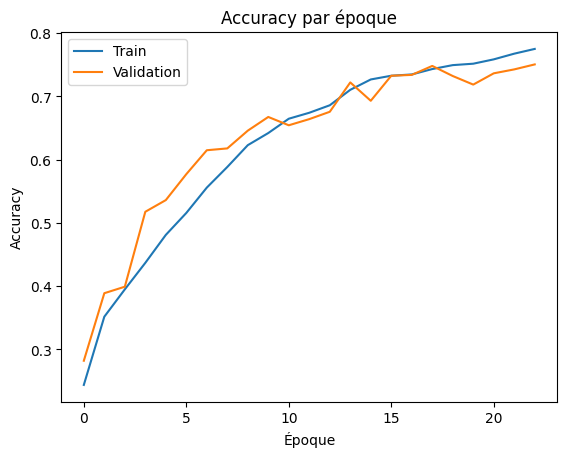

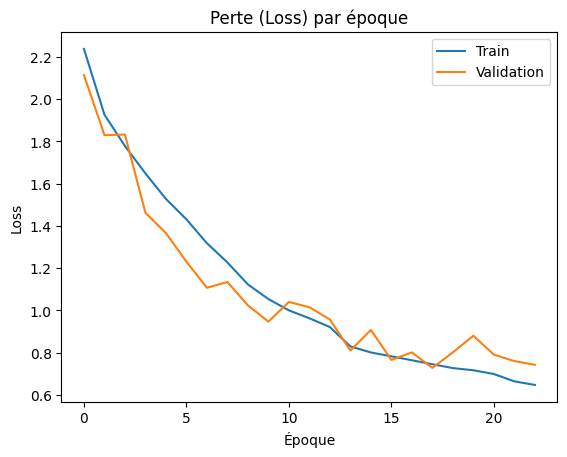

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy par époque")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Perte (Loss) par époque")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# On désactive le shuffle pour que les labels soient bien alignés
val_loader.shuffle = False

# Prédictions sur le dataset de validation
y_pred_proba = model.predict(val_loader)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = val_loader.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Matrice de confusion - Validation")
plt.show()


302/302 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step


NameError: name 'class_names' is not defined

In [ ]:
# Charger le fichier .npz fourni pour la compétition
import numpy as np

data = np.load(npz_path)

# Extraction des images (normalement sous la clé 'arr_0')
x_test = data['X']
print("Shape des images test :", x_test.shape)

# Normalisation comme pour les données d'entraînement
x_test = x_test.astype('float32') / 255.0


Shape des images test : (2000, 32, 32, 3)


In [ ]:
# Prédiction des probabilités
y_test_proba = model.predict(x_test)

# Classe prédite = index de la probabilité max
y_test_pred = np.argmax(y_test_proba, axis=1)
print("Extrait des prédictions :", y_test_pred[:10])


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Extrait des prédictions : [ 5  3  8  6  5  0  1  1  3 12]


In [ ]:
import pandas as pd

# Créer un DataFrame avec ID et Category
submission_df = pd.DataFrame({
    "ID": np.arange(len(y_test_pred)),
    "Category": y_test_pred
})

# Sauvegarde en CSV (dans Colab)
csv_output_path = "/content/ships_competition.csv"
submission_df.to_csv(csv_output_path, index=False)

print("Fichier de soumission généré :", csv_output_path)
!cp /content/ships_competition.csv /content/drive/MyDrive/SHIP32/


Fichier de soumission généré : /content/ships_competition.csv
